# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

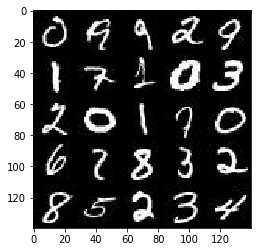

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

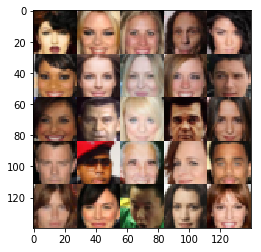

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units = 4 * 4 * 256
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, n_units))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    num_units = 7*7*512
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, num_units)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same',
                                       activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same',
                                       activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3) 
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same',
                                           activation=None)
        # shape = 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    gen_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(gen_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_real,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
        
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    # show samples
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5380... Generator Loss: 16.5804
Epoch 1/2... Discriminator Loss: 0.3465... Generator Loss: 7.3025
Epoch 1/2... Discriminator Loss: 0.3494... Generator Loss: 5.4948
Epoch 1/2... Discriminator Loss: 0.3611... Generator Loss: 3.8447
Epoch 1/2... Discriminator Loss: 0.9580... Generator Loss: 7.5752
Epoch 1/2... Discriminator Loss: 4.2370... Generator Loss: 0.8353
Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 2.1878
Epoch 1/2... Discriminator Loss: 2.2794... Generator Loss: 3.2877
Epoch 1/2... Discriminator Loss: 1.5186... Generator Loss: 0.4978
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 1.2380


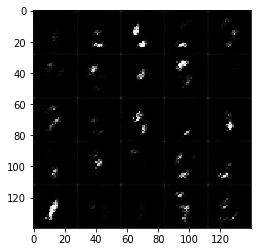

Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 1.0439
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 1.2407
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.9726
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 0.9752
Epoch 1/2... Discriminator Loss: 1.4586... Generator Loss: 0.5132
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 1.2066
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 1.0984... Generator Loss: 1.2743


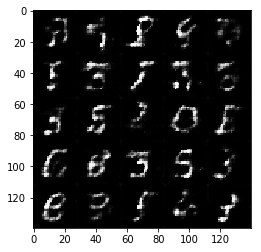

Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 1.0732
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 1.1294
Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.9009
Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.6948
Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 1.2614... Generator Loss: 0.8668


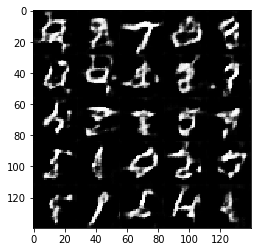

Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 1.7152
Epoch 1/2... Discriminator Loss: 1.5157... Generator Loss: 1.5648
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 1.1308
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 1.1509
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 1.3520
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 1.2851
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.8532


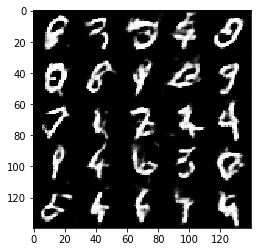

Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 1.2958
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 1.3629
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.8693
Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 1.4166
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 1.2193
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 1.5365
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.5185


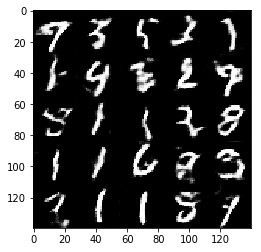

Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 0.6744
Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 1.9913
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.9254
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 1.0034
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 0.8890
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 1.3785
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 1.1287
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.7872


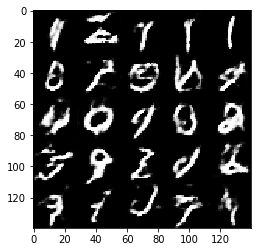

Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 0.9638
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 1.1960
Epoch 1/2... Discriminator Loss: 1.1370... Generator Loss: 0.9650
Epoch 1/2... Discriminator Loss: 1.5501... Generator Loss: 0.4150
Epoch 1/2... Discriminator Loss: 1.1038... Generator Loss: 0.9204
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 1.2157
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 1.2725


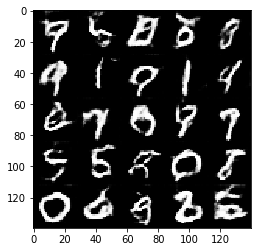

Epoch 1/2... Discriminator Loss: 1.6570... Generator Loss: 0.3783
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 1.0379
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 0.8548
Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 0.4684
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 0.8481
Epoch 1/2... Discriminator Loss: 1.4983... Generator Loss: 0.4532
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 1.1796
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.2367


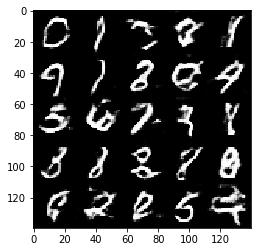

Epoch 1/2... Discriminator Loss: 1.6408... Generator Loss: 2.2337
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.9060
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.4873
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 1.3812
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.8887


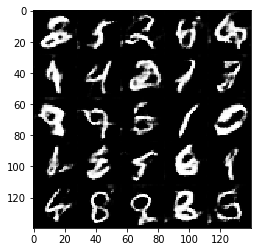

Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 1.6804
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 1.1036
Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 1.2562
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.6002
Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 0.9762... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.5916


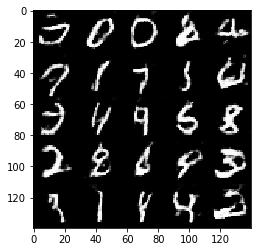

Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.5474
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 1.1041
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.9411
Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.9463
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 0.5628
Epoch 2/2... Discriminator Loss: 1.4823... Generator Loss: 0.5081


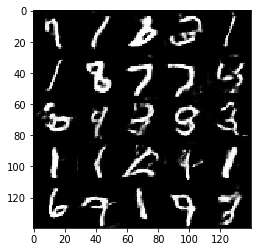

Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 1.0753
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 1.6265
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.5293
Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 0.9016
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 0.9810
Epoch 2/2... Discriminator Loss: 1.5158... Generator Loss: 2.0886
Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 1.0339
Epoch 2/2... Discriminator Loss: 1.2956... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 0.6825


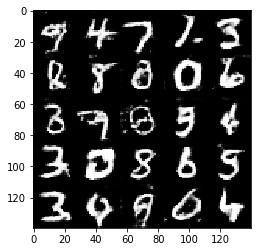

Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 1.1089
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.6431
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.8079
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 1.0237
Epoch 2/2... Discriminator Loss: 1.7605... Generator Loss: 2.4151
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 2.1037
Epoch 2/2... Discriminator Loss: 1.1266... Generator Loss: 0.8066


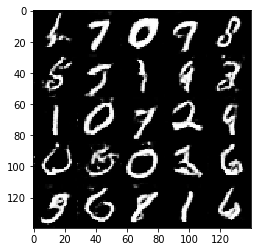

Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 0.8046
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 1.4007
Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 0.5957
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 1.2255
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 0.9705
Epoch 2/2... Discriminator Loss: 2.1021... Generator Loss: 0.2625
Epoch 2/2... Discriminator Loss: 1.2432... Generator Loss: 0.7074
Epoch 2/2... Discriminator Loss: 1.2590... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 1.1259... Generator Loss: 1.9783


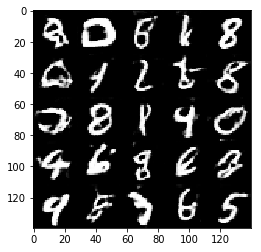

Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 1.2566
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 1.2848... Generator Loss: 0.6168
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 1.2314
Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 1.8640
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 1.1461
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 1.1519
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 1.5381... Generator Loss: 0.4418


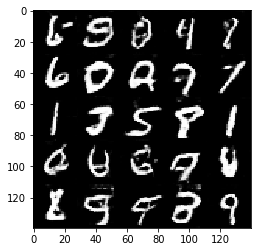

Epoch 2/2... Discriminator Loss: 1.5812... Generator Loss: 0.4518
Epoch 2/2... Discriminator Loss: 1.4926... Generator Loss: 0.4876
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 1.1202
Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 2.4864
Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 1.0625
Epoch 2/2... Discriminator Loss: 1.4729... Generator Loss: 0.4734
Epoch 2/2... Discriminator Loss: 1.0274... Generator Loss: 1.1815
Epoch 2/2... Discriminator Loss: 0.9921... Generator Loss: 0.9799
Epoch 2/2... Discriminator Loss: 1.7979... Generator Loss: 0.3533
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.9294


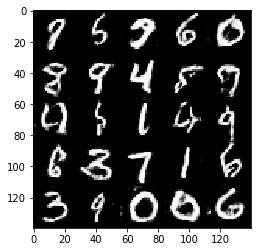

Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 1.0312
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 1.9245
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 1.4150
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.6068
Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 1.2573
Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 2.4101
Epoch 2/2... Discriminator Loss: 1.4748... Generator Loss: 0.5235
Epoch 2/2... Discriminator Loss: 1.6800... Generator Loss: 0.3762


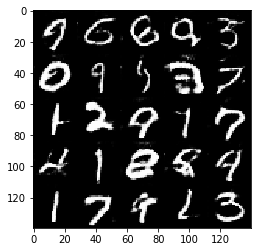

Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 1.5203
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 0.9336
Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 1.4480
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.5974
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 1.4057
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 1.4511


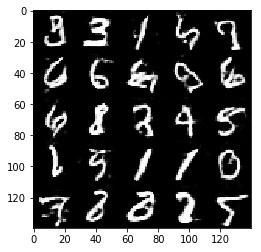

Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 1.3057
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 0.5207
Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 1.7996
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 1.3570
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 1.0986


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 27.3105
Epoch 1/1... Discriminator Loss: 1.8128... Generator Loss: 3.3243
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 4.2963
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 3.1633
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.5495
Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 2.9787


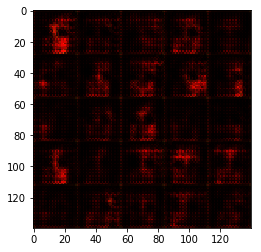

Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 2.3320
Epoch 1/1... Discriminator Loss: 3.7735... Generator Loss: 0.0517
Epoch 1/1... Discriminator Loss: 3.0946... Generator Loss: 7.9400
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 2.1602... Generator Loss: 0.3096
Epoch 1/1... Discriminator Loss: 3.5984... Generator Loss: 3.6381
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.9362... Generator Loss: 0.3123
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7707


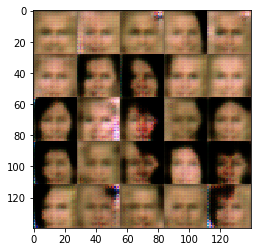

Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 2.2460... Generator Loss: 0.2053
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.6476... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7588


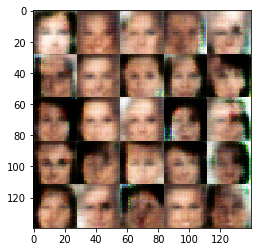

Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 2.2590
Epoch 1/1... Discriminator Loss: 1.6112... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 1.6566
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 1.8530


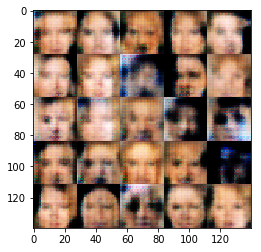

Epoch 1/1... Discriminator Loss: 3.0200... Generator Loss: 3.7900
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 2.4006... Generator Loss: 2.4177
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.5425


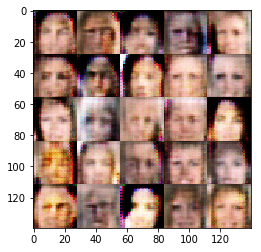

Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 1.7009... Generator Loss: 2.4135
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 2.4829... Generator Loss: 3.0409
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 1.3571


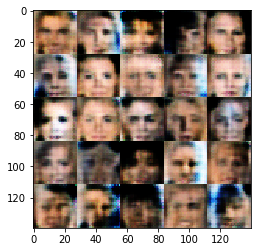

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.9500


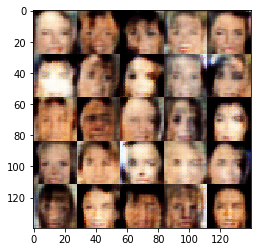

Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 1.3009
Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.3617
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 1.4380
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 1.7634
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.5927


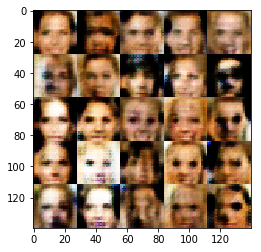

Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6064


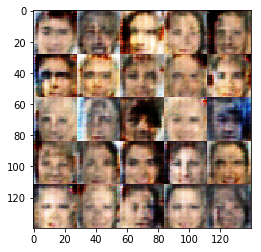

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 1.2174
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 1.2844
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6903


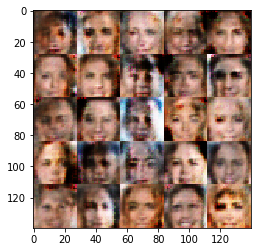

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 2.2470
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.9467


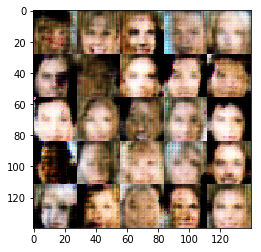

Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.7228... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.7923


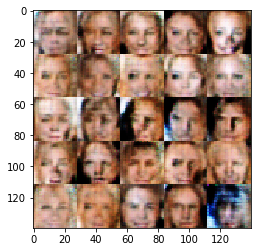

Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 1.8788
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.7566


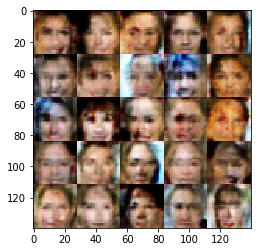

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 1.3343
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 1.8376
Epoch 1/1... Discriminator Loss: 2.1570... Generator Loss: 2.3718
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.0450


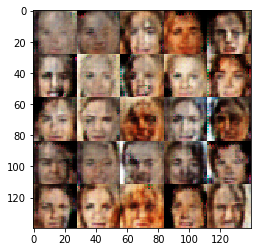

Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 2.0020
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.2813


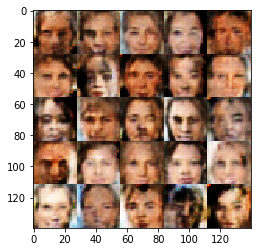

Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 1.7475
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.8999


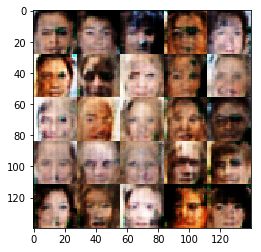

Epoch 1/1... Discriminator Loss: 1.6338... Generator Loss: 0.3725
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6513


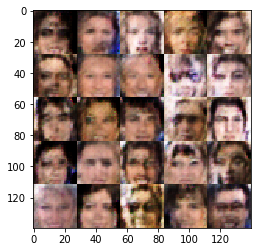

Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8416


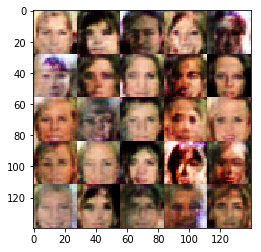

Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.6800... Generator Loss: 0.3937
Epoch 1/1... Discriminator Loss: 2.0076... Generator Loss: 2.2575
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 1.4155


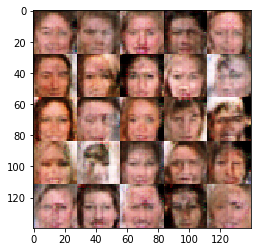

Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.6219... Generator Loss: 0.3774
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.6374


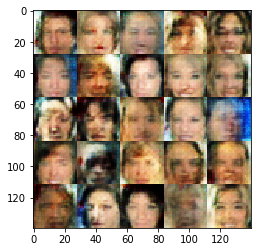

Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7656


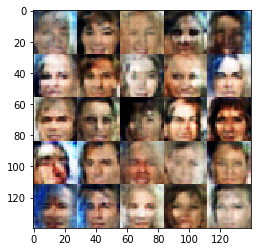

Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.9303


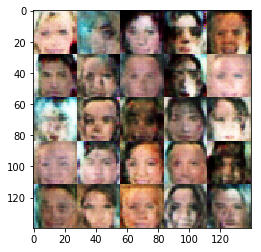

Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8200


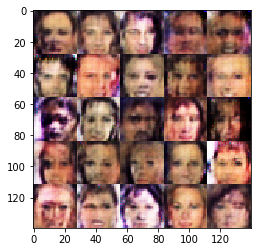

Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7703


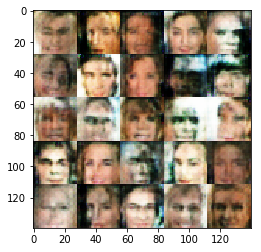

Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.9873


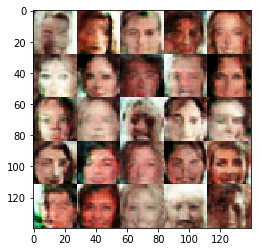

Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.7587


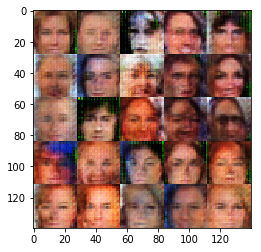

Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8526


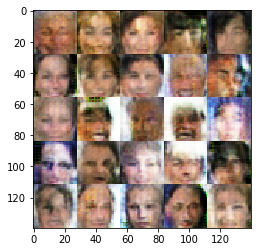

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7555


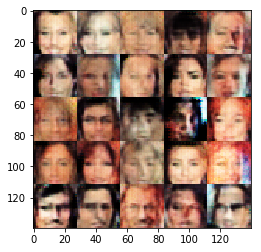

Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7465


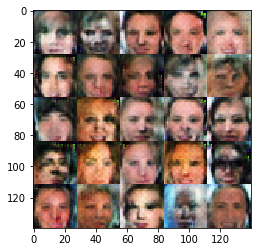

Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.1865


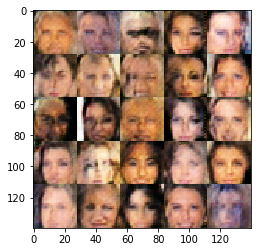

Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 1.1744
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7389


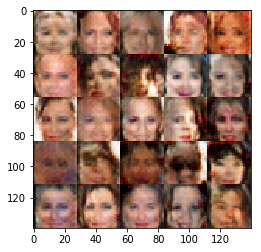

Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7678


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.